In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import tensorflow as tf

# For reproducibility...
np.random.seed(0)
tf.random.set_seed(0)

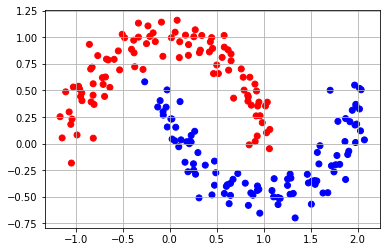

In [2]:
# Generate moon dataset from sklearn
X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)

c = ["red" if y_ == 0 else "blue" for y_ in y]
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.grid()
plt.show()

In [3]:
#Generate quantum model
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

clayer1_q = tf.keras.layers.Dense(2)
clayer2_q = tf.keras.layers.Dense(2, activation="softmax")
model_q = tf.keras.models.Sequential([clayer1_q, qlayer, clayer2_q], name="Quantum")
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model_q.compile(opt, loss="mse", metrics=["accuracy"])


In [4]:
# Generate not quantum model
nqlayer = tf.keras.layers.Dense(4)

clayer1_nq = tf.keras.layers.Dense(2)
clayer2_nq = tf.keras.layers.Dense(2, activation="softmax")
model_nq = tf.keras.models.Sequential([clayer1_nq, nqlayer, clayer2_nq], name="Not_Quantum")
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model_nq.compile(opt, loss="mse", metrics=["accuracy"])

In [5]:
model_q.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)
model_q.summary()

Epoch 1/6
30/30 - 7s - loss: 0.2022 - accuracy: 0.6733 - val_loss: 0.1489 - val_accuracy: 0.8800
Epoch 2/6
30/30 - 7s - loss: 0.1658 - accuracy: 0.7200 - val_loss: 0.1117 - val_accuracy: 0.8800
Epoch 3/6
30/30 - 7s - loss: 0.1437 - accuracy: 0.7467 - val_loss: 0.0882 - val_accuracy: 0.8800
Epoch 4/6
30/30 - 7s - loss: 0.1212 - accuracy: 0.8267 - val_loss: 0.0996 - val_accuracy: 0.9000
Epoch 5/6
30/30 - 7s - loss: 0.1221 - accuracy: 0.7933 - val_loss: 0.0641 - val_accuracy: 0.9600
Epoch 6/6
30/30 - 7s - loss: 0.1151 - accuracy: 0.8333 - val_loss: 0.0583 - val_accuracy: 0.9600
Model: "Quantum"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (5, 2)                    6         
_________________________________________________________________
keras_layer (KerasLayer)     (5, 2)                    12        
_________________________________________________________________
dense

In [6]:
model_nq.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)
model_nq.summary()

Epoch 1/6
30/30 - 0s - loss: 0.1222 - accuracy: 0.8133 - val_loss: 0.0664 - val_accuracy: 0.9000
Epoch 2/6
30/30 - 0s - loss: 0.1139 - accuracy: 0.8000 - val_loss: 0.0557 - val_accuracy: 0.9600
Epoch 3/6
30/30 - 0s - loss: 0.1052 - accuracy: 0.8533 - val_loss: 0.0538 - val_accuracy: 0.9400
Epoch 4/6
30/30 - 0s - loss: 0.0983 - accuracy: 0.8467 - val_loss: 0.0560 - val_accuracy: 0.9200
Epoch 5/6
30/30 - 0s - loss: 0.1062 - accuracy: 0.8267 - val_loss: 0.0470 - val_accuracy: 0.9600
Epoch 6/6
30/30 - 0s - loss: 0.1043 - accuracy: 0.8400 - val_loss: 0.0457 - val_accuracy: 0.9600
Model: "Not_Quantum"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (5, 2)                    6         
_________________________________________________________________
dense_2 (Dense)              (5, 4)                    12        
_________________________________________________________________
d

In [7]:
# Now let's compare the results!
X_test, y_test = make_moons(n_samples=200, noise=0.1)
y_hot_test = tf.keras.utils.to_categorical(y, num_classes=2)

y_pred_q = np.argmax(model_q.predict(X_test), axis=-1)
y_pred_nq = np.argmax(model_nq.predict(X_test), axis=-1)

In [8]:
def acc(Y,y_pred):
    n = len(Y)
    correct = 0
    for y, y_ in zip(Y,y_pred):
        if y == y_:
            correct +=1
    return correct/n

Quantum model accuracy: 88.5 %


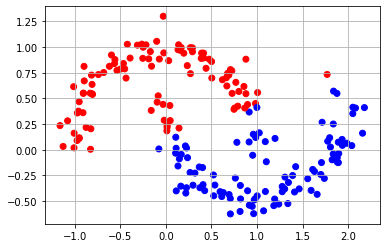

In [9]:
# Quantum model performance
print(f'Quantum model accuracy: {100*acc(y_test,y_pred_q)} %')
c = ["red" if y_ == 0 else "blue" for y_ in y_pred_q]

plt.grid()
plt.scatter(X_test[:, 0], X_test[:, 1], c=c)
plt.show()

Non Quantum model accuracy: 89.0 %


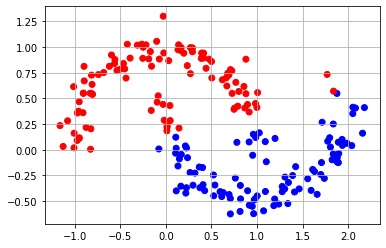

In [10]:
print(f'Non Quantum model accuracy: {100*acc(y_test,y_pred_nq)} %')
# Non Quantum model performance
c = ["red" if y_ == 0 else "blue" for y_ in y_pred_nq]

plt.grid()
plt.scatter(X_test[:, 0], X_test[:, 1], c=c)
plt.show()